In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from box_io import load_beeframe_meta_from_box
from comb_loading import get_organized_colony_names
from comb_loading import load_colony_comb    
from mask_processing import get_distance_to_class
from mask_processing import get_interior_mask, dilate_class

In [2]:
comb_class = 2
wood_class = 1

load_meta_from_file = True
if load_meta_from_file:
    meta_file = "/home/golden/Dropbox/bee-comb/img_to_text_df_TOEDIT.csv"
    beeframe_meta = pd.read_csv(meta_file)
else:
    # Only if don't have local copy of "img_to_text_df_TOEDIT.csv"
    # These variable need to be changed to match user
    comb_meta_filename = "img_to_text_df_TOEDIT.csv"
    box_config_file = "/home/golden/kenya_drones/comb-detection/config.json"
    box_user_id = '15809502026'
    meta_folder_id = "133070825445"
    beeframe_meta = load_beeframe_meta_from_box(comb_meta_filename, 
                                               box_config_file,
                                               box_user_id,
                                               meta_folder_id
                                              )

In [3]:
colony_names = get_organized_colony_names(beeframe_meta)

In [4]:
masks_folder_root = "/home/golden/kenya_drones/comb-detection/nest_photos"
colony_name = colony_names[2]
masks_folder_name = "warped_masks"
colony = load_colony_comb(beeframe_meta, colony_name, 
                          masks_folder_root, masks_folder_name,
                          combine_ab=True, mirror_b=True
                         )
# Sometimes there is a thin layer of false wood on comb edge
# try to clean this up
for day_ind, day in enumerate(colony):
    for frame_ind, frame in enumerate(day):
        colony[day_ind, frame_ind] = dilate_class(frame, comb_class, 4)
print(f"loaded colony {colony_name}")

loaded colony DD4


comb distance: 77.07788269017254
wood distance: 135.0


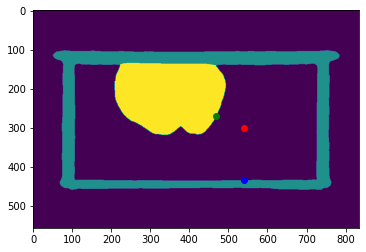

In [5]:
# Visualize closest comb and wood to point in mask
mask = colony[3, 4]
plt.imshow(mask)
point = [300, 540]
distance, comb_position = get_distance_to_class(point, mask, class_id=comb_class)
print(f"comb distance: {distance}")
plt.scatter(*point[::-1], c='r')
plt.scatter(*comb_position[::-1], c='g')
distance, wood_position = get_distance_to_class(point, mask, class_id=wood_class)
print(f"wood distance: {distance}")
plt.scatter(*wood_position[::-1], c='b')

In [6]:
interior_mask = get_interior_mask(colony[0,0])

In [7]:
# build dataset
num_points = 6000


feature_distances = []
comb_presence = []

for _ in range(num_points):
    # -1 so we don't choose the last frame where we don't know about future growth
    week = np.random.randint(colony.shape[0]-1)
    frame_num = np.random.randint(colony[week].shape[0])
    mask0 = colony[week, frame_num]
    mask1 = colony[week+1, frame_num]
    empty_inds = np.argwhere((mask0==0)&(interior_mask))
    rand_ind = np.random.randint(empty_inds.shape[0])
    point = empty_inds[rand_ind]
    
    comb_distance, _ = get_distance_to_class(point, mask0, class_id=comb_class)
    if not comb_distance:
        # no comb present yet in this frame so ignore for this initial analysis
        continue
    wood_distance, _ = get_distance_to_class(point, mask0, class_id=wood_class)
    
    if comb_distance == 0:
        break
    
    feature_distances.append(np.array([comb_distance, wood_distance]))
    
    # Is there comb next week
    if mask1[point[0], point[1]] == comb_class:
        comb_presence.append(1)
    else:
        comb_presence.append(0)
    
feature_distances = np.stack(feature_distances, axis=0) 
comb_presence = np.array(comb_presence)

In [9]:
bin_size = 20
max_wood_distance = np.max(feature_distances[:, 1])
max_comb_distance = np.max(feature_distances[:, 0])
binned_comb = np.digitize(feature_distances[:, 0], 
                          np.arange(0, max_comb_distance, bin_size), 
                          right=True)
binned_wood = np.digitize(feature_distances[:, 1], 
                          np.arange(0, max_wood_distance, bin_size), 
                          right=True)

prob_growth_comb = []
prob_growth_wood = []
comb_bin_centers = []
wood_bin_centers = []

for bin_val in range(binned_comb.max()):
    
    prob_growth = np.mean(comb_presence[binned_comb==bin_val])
    prob_growth_comb.append(prob_growth)
    comb_bin_centers.append(int((bin_val * bin_size) - (bin_size / 2)))
for bin_val in range(binned_wood.max()):
    prob_growth = np.mean(comb_presence[binned_wood==bin_val])
    prob_growth_wood.append(prob_growth)
    wood_bin_centers.append(int((bin_val * bin_size) - (bin_size / 2)))

Text(0, 0.5, 'new comb')

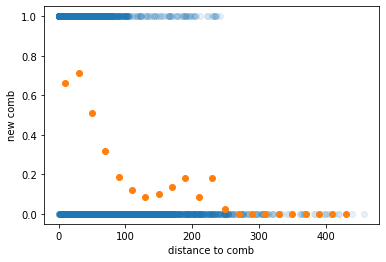

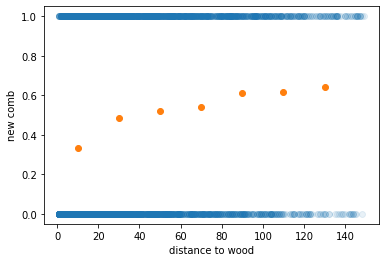

In [11]:
plt.figure()
plt.scatter(feature_distances[:, 0], comb_presence, alpha=.1)
plt.scatter(comb_bin_centers, 
            prob_growth_comb)
plt.xlabel("distance to comb")
plt.ylabel("new comb")
plt.figure()
plt.scatter(feature_distances[:, 1], comb_presence, alpha=.1)
plt.scatter(wood_bin_centers,
            prob_growth_wood)
plt.xlabel("distance to wood")
plt.ylabel("new comb")

Text(0.5, 0, 'distance to comb')

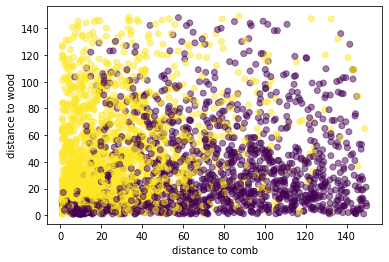

In [12]:
plt.scatter(feature_distances[:, 0][feature_distances[:, 0]<150], 
            feature_distances[:, 1][feature_distances[:, 0]<150], 
            c=comb_presence[feature_distances[:, 0]<150], 
            alpha=.5
           )
plt.ylabel("distance to wood")
plt.xlabel("distance to comb")